In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

# Load data from CSV
file_path = 'final_manglish_transliterated.csv'  # Replace with your file path
data = pd.read_csv(file_path)

# Ensure 'commentText' column contains strings
data['transliterated_text'] = data['transliterated_text'].astype(str)

# Function to convert sentiment labels to numerical values
sentiment_dict = {
    'Positive': 0,
    'Negative': 1,
    'Not_relevant': 2,
    'Mixed Feelings': 3,
    'Neutral': 4
}

data['Sentiment_Class'] = data['Sentiment_Class'].map(sentiment_dict)

# Tokenization and sequence padding
max_words = 1000
max_seq_length = 100
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(data['transliterated_text'])

sequences = tokenizer.texts_to_sequences(data['transliterated_text'])
padded_sequences = pad_sequences(sequences, maxlen=max_seq_length, padding='post', truncating='post')

# Prepare target variable
labels = np.asarray(data['Sentiment_Class'])

# Upsample minority classes to match the size of the majority class
data_upsampled = pd.concat([
    resample(data[data['Sentiment_Class'] == sentiment_dict['Positive']], replace=True, n_samples=len(data[data['Sentiment_Class'] == sentiment_dict['Not_relevant']])),
    resample(data[data['Sentiment_Class'] == sentiment_dict['Negative']], replace=True, n_samples=len(data[data['Sentiment_Class'] == sentiment_dict['Not_relevant']])),
    resample(data[data['Sentiment_Class'] == sentiment_dict['Not_relevant']], replace=True, n_samples=len(data[data['Sentiment_Class'] == sentiment_dict['Not_relevant']])),
    resample(data[data['Sentiment_Class'] == sentiment_dict['Mixed Feelings']], replace=True, n_samples=len(data[data['Sentiment_Class'] == sentiment_dict['Not_relevant']])),
    resample(data[data['Sentiment_Class'] == sentiment_dict['Neutral']], replace=True, n_samples=len(data[data['Sentiment_Class'] == sentiment_dict['Not_relevant']]))
])

# Tokenization and sequence padding for balanced data
sequences_upsampled = tokenizer.texts_to_sequences(data_upsampled['transliterated_text'])
padded_sequences_upsampled = pad_sequences(sequences_upsampled, maxlen=max_seq_length, padding='post', truncating='post')

# Prepare target variable for upsampled data
labels_upsampled = np.asarray(data_upsampled['Sentiment_Class'])

# Split the upsampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences_upsampled, labels_upsampled, test_size=0.05, random_state=141)

# Build Bi-GRU model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=16))
model.add(Bidirectional(GRU(32)))
model.add(Dense(5, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training the model with early stopping
callbacks = [EarlyStopping(monitor='val_loss', patience=3)]

history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.05, callbacks=callbacks)

# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Generate predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert numerical labels back to original sentiment labels
reverse_sentiment_dict = {v: k for k, v in sentiment_dict.items()}
y_test_labels = [reverse_sentiment_dict[label] for label in y_test]
y_pred_labels = [reverse_sentiment_dict[label] for label in y_pred_classes]

# Print complete classification report
print(classification_report(y_test_labels, y_pred_labels, target_names=sentiment_dict.keys()))


Epoch 1/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.3660 - loss: 1.4346 - val_accuracy: 0.5950 - val_loss: 0.9932
Epoch 2/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.6391 - loss: 0.9233 - val_accuracy: 0.7001 - val_loss: 0.8022
Epoch 3/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.7236 - loss: 0.7428 - val_accuracy: 0.7430 - val_loss: 0.7064
Epoch 4/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.7626 - loss: 0.6621 - val_accuracy: 0.7704 - val_loss: 0.6642
Epoch 5/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.7822 - loss: 0.6022 - val_accuracy: 0.7597 - val_loss: 0.6725
Epoch 6/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.7901 - loss: 0.5859 - val_accuracy: 0.7597 - val_loss: 0.6679
Epoch 7/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.8012 - loss: 0.5683 - val_accuracy: 0.7724 - val_loss: 0.6332
Epoch 8/10
444/444 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.8106 - loss: 0.5438 - 

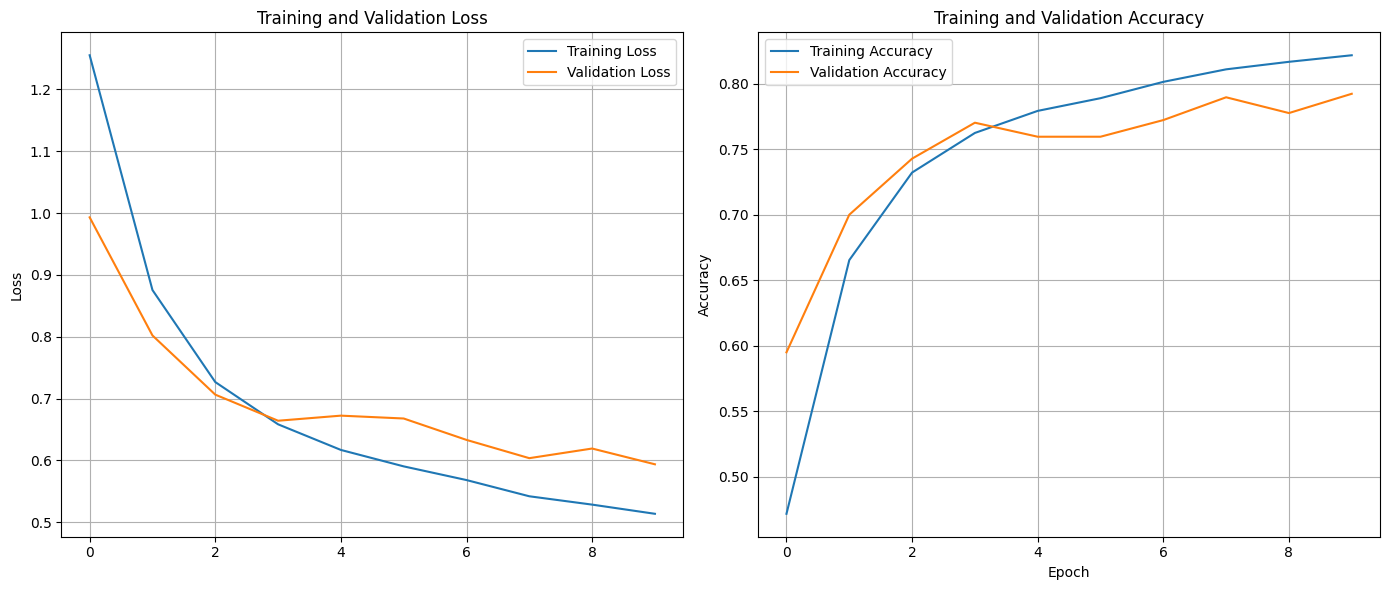

In [2]:
import matplotlib.pyplot as plt

# Create a figure and axes for horizontal subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

# Plot Training and Validation Loss
axs[0].plot(history.history['loss'], label='Training Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training and Validation Loss')
axs[0].legend()
axs[0].grid(True)

# Plot Training and Validation Accuracy
axs[1].plot(history.history['accuracy'], label='Training Accuracy')
axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Training and Validation Accuracy')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()  # Adjust spacing between subplots
plt.show()
